In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any

import sys
import os

src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from gratis_precip.features import (
    # Base features
    LengthFeature,
    NPeriodsFeature,
    PeriodsFeature,
    NDiffsFeature,
    NSDiffsFeature,
    ACFFeature,
    PACFFeature,
    EntropyFeature,
    NonlinearityFeature,
    HurstFeature,
    StabilityFeature,
    LumpinessFeature,
    UnitRootFeature,
    HeterogeneityFeature,
    TrendFeature,
    SeasonalStrengthFeature,
    SpikeFeature,
    LinearityFeature,
    CurvatureFeature,
    RemainderACFFeature,
    ARCHACFFeature,
    GARCHACFFeature,
    ARCHR2Feature,
    GARCHR2Feature,
    # Precipitation-specific features
    TotalPrecipitation,
    PrecipitationIntensity,
    DrySpellDuration,
    WetSpellDuration,
    PrecipitationVariability,
    ExtremePrecipitationFrequency,
    MaximumDailyPrecipitation,
    WetDayFrequency,
)
from gratis_precip.dimensionality_reduction import (
    DimensionalityReducer,
    TSNEReduction,
    PCAReduction,
)

import warnings

warnings.filterwarnings("ignore")

import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

In [2]:
# Load the precipitation data
df = pd.read_csv("/Users/cooper/Desktop/gratis-precip/data/GSTEIGmeteo copy.csv")
precipitation = df["P_mix"].values


In [3]:
def split_into_seasons(
    precipitation: np.ndarray, days_per_season: int = 90
) -> Tuple[List[np.ndarray], List[str]]:
    """
    Split a long precipitation time series into seasonal segments.

    Args:
        precipitation (np.ndarray): The full precipitation time series.
        days_per_season (int): Number of days to consider for each season.

    Returns:
        Tuple[List[np.ndarray], List[str]]: List of seasonal segments and their corresponding season labels.
    """
    segments = []
    labels = []
    seasons = ["Winter", "Spring", "Summer", "Autumn"]

    for i in range(0, len(precipitation) - days_per_season + 1, days_per_season):
        segment = precipitation[i : i + days_per_season]
        segments.append(segment)
        labels.append(seasons[(i // days_per_season) % 4])

    return segments, labels


def classify_seasons(segments: List[np.ndarray], labels: List[str]) -> List[str]:
    """
    Classify seasons as 'Dry' or 'Wet' based on total precipitation.

    Args:
        segments (List[np.ndarray]): List of seasonal precipitation segments.
        labels (List[str]): List of corresponding season labels.

    Returns:
        List[str]: List of classified season labels.
    """
    totals = [np.sum(segment) for segment in segments]
    median = np.median(totals)

    classified_labels = []
    for total, label in zip(totals, labels):
        if total < median:
            classified_labels.append(f"Dry {label}")
        else:
            classified_labels.append(f"Wet {label}")

    return classified_labels

In [4]:
# Split the precipitation data into seasonal segments
segments, season_labels = split_into_seasons(precipitation, days_per_season=365)

# Classify the seasons
classified_labels = classify_seasons(segments, season_labels)

In [5]:
def flatten(item):
    """Recursively flatten an arbitrarily nested iterable."""
    if isinstance(item, (list, tuple, np.ndarray)):
        return [sub_item for i in item for sub_item in flatten(i)]
    else:
        return [item]


class FeatureExtractor:
    def __init__(self, features: List[Any]):
        self.features = features

    def extract_features(self, time_series: np.ndarray) -> Dict[str, Any]:
        return {
            feature.__class__.__name__: feature.calculate(time_series)
            for feature in self.features
        }

    def extract_feature_matrix(self, time_series_list: List[np.ndarray]) -> np.ndarray:
        all_feature_vectors = []

        for ts in time_series_list:
            features = self.extract_features(ts)
            feature_vector = []
            for value in features.values():
                feature_vector.extend(flatten(value))
            all_feature_vectors.append(feature_vector)

        # Find the maximum length of feature vectors
        max_length = max(len(vector) for vector in all_feature_vectors)

        # Pad shorter vectors with zeros
        uniform_feature_vectors = [
            vector + [0] * (max_length - len(vector)) for vector in all_feature_vectors
        ]

        return np.array(uniform_feature_vectors)

In [6]:
extractor = FeatureExtractor(
    [
        # Base features
        LengthFeature(),
        NPeriodsFeature(),
        PeriodsFeature(),
        NDiffsFeature(),
        NSDiffsFeature(),
        ACFFeature(),
        PACFFeature(),
        EntropyFeature(),
        NonlinearityFeature(),
        HurstFeature(),
        StabilityFeature(),
        LumpinessFeature(),
        UnitRootFeature(),
        HeterogeneityFeature(),
        TrendFeature(),
        SeasonalStrengthFeature(),
        SpikeFeature(),
        LinearityFeature(),
        CurvatureFeature(),
        RemainderACFFeature(),
        ARCHACFFeature(),
        GARCHACFFeature(),
        ARCHR2Feature(),
        GARCHR2Feature(),
        # Precipitation-specific features
        TotalPrecipitation(),
        PrecipitationIntensity(),
        DrySpellDuration(),
        WetSpellDuration(),
        PrecipitationVariability(),
        ExtremePrecipitationFrequency(),
        MaximumDailyPrecipitation(),
        WetDayFrequency(),
    ]
)


In [7]:
# Extract features for all segments
feature_matrix = extractor.extract_feature_matrix(segments)
print(f"Feature matrix shape: {feature_matrix.shape}")

Feature matrix shape: (14, 42)


In [8]:
segments

[array([ 2.5,  0.2,  4.3,  3.4,  3.6,  2. ,  0.5,  6.7,  2.6,  9.1, 16. ,
         9.3, 31.5,  8.7, 12.9, 23. ,  0. ,  5.6, 16.1,  0. ,  0. ,  0.7,
        19. , 20.9, 13.1,  3.9,  0. ,  0. ,  0. ,  7.2, 31.8,  2.9,  0.1,
         0. ,  0. ,  0. ,  0. ,  0.6,  1. ,  1.2,  0. ,  0. ,  0. ,  0. ,
         0. ,  0.3,  0.3,  0. ,  2.4,  7.6,  0. ,  0. ,  1.8,  8.6,  2.7,
         0. ,  0. ,  0.4,  0.1,  0. ,  0.1,  7. ,  0. ,  0. ,  3.4,  0.8,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.6,
        13.4, 11.2,  9.3,  0.1, 16. ,  7.9,  3.7,  0.1,  0. , 14.3,  2.8,
         3.8,  6.9,  0. ,  0. , 19.8,  0.1,  3. ,  0. ,  4.8,  1.4, 36.3,
         6.8,  4. ,  4.2,  0.4,  0. ,  0. ,  1. , 18.1, 10.4,  8.6,  5.8,
         0.8,  5.6,  1.8, 11.5,  0. ,  1.5, 28.2,  3.4,  3.3,  0.2,  0. ,
         0. ,  0.1,  0.1,  0.1,  0. , 11.7,  0. ,  0. ,  0. ,  2.2,  0. ,
         0. ,  2.7,  2.7,  6.5,  0. ,  0. ,  4. ,  0. , 20.8,  0. , 11.4,
         3.4,  0. ,  0. , 11.9, 17.6, 

In [9]:
# Perform dimensionality reduction
reducer = DimensionalityReducer(PCAReduction())
projection = reducer.reduce_dimensions(feature_matrix)

In [10]:
from scipy.spatial.distance import cdist


def find_center(coordinates):
    coordinates = np.array(coordinates)
    center_x = np.mean(coordinates[:, 0])
    center_y = np.mean(coordinates[:, 1])
    return np.array([center_x, center_y])

def find_medoid(coordinates):
    coordinates = np.array(coordinates)
    distance_matrix = cdist(coordinates, coordinates, metric='euclidean')
    medoid_index = np.argmin(distance_matrix.sum(axis=1))
    medoid = coordinates[medoid_index]
    return medoid

center = find_center(projection)
medoid = find_medoid(projection)

print(center)
print(f"medoid: {medoid}")

[ 1.50229036e-13 -3.32940025e-13]
medoid: [-627.73956946   -9.27923245]


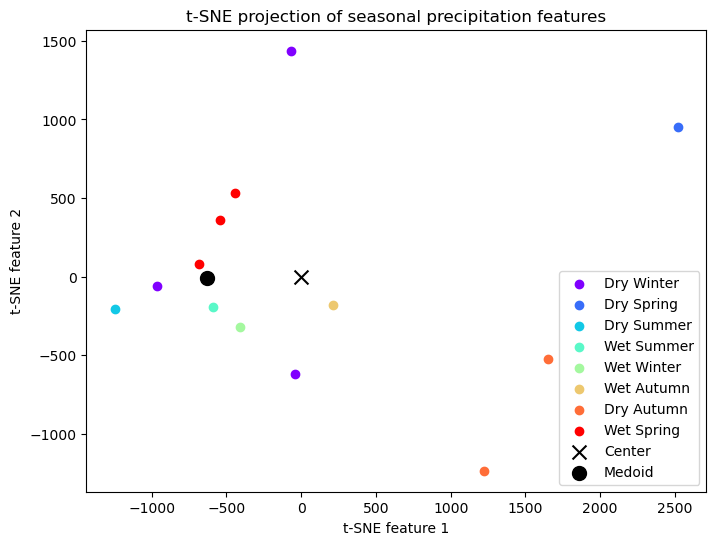

In [11]:
# Visualize the projection
plt.figure(figsize=(8, 6))

unique_labels = list(set(classified_labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = np.array(classified_labels) == label
    plt.scatter(projection[mask, 0], projection[mask, 1], label=label, color=color)

plt.scatter(center[0], center[1], label="Center", color="black", marker="x", s=100)
plt.scatter(medoid[0], medoid[1], label="Medoid", color="black", marker="o", s=100)
plt.title("t-SNE projection of seasonal precipitation features")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend()
plt.show()

In [12]:
# Print some statistics
for season in set(classified_labels):
    season_data = [
        seg for seg, label in zip(segments, classified_labels) if label == season
    ]
    print(f"\n{season} statistics:")
    print(
        f"  Average daily precipitation: {np.mean([np.mean(seg) for seg in season_data]):.2f}"
    )
    print(
        f"  Total seasonal precipitation: {np.mean([np.sum(seg) for seg in season_data]):.2f}"
    )
    print(
        f"  Maximum daily precipitation: {np.max([np.max(seg) for seg in season_data]):.2f}"
    )


Dry Winter statistics:
  Average daily precipitation: 3.72
  Total seasonal precipitation: 1357.97
  Maximum daily precipitation: 68.10

Dry Spring statistics:
  Average daily precipitation: 3.62
  Total seasonal precipitation: 1320.80
  Maximum daily precipitation: 73.00

Dry Summer statistics:
  Average daily precipitation: 3.86
  Total seasonal precipitation: 1409.70
  Maximum daily precipitation: 29.80

Wet Summer statistics:
  Average daily precipitation: 3.97
  Total seasonal precipitation: 1450.00
  Maximum daily precipitation: 49.40

Wet Winter statistics:
  Average daily precipitation: 4.23
  Total seasonal precipitation: 1544.20
  Maximum daily precipitation: 36.30

Wet Autumn statistics:
  Average daily precipitation: 3.87
  Total seasonal precipitation: 1411.80
  Maximum daily precipitation: 50.60

Dry Autumn statistics:
  Average daily precipitation: 3.47
  Total seasonal precipitation: 1267.30
  Maximum daily precipitation: 49.00

Wet Spring statistics:
  Average daily p

In [13]:
from gratis_precip.models import ARMAComponent, CompositeComponent, MARDataGenerator
from gratis_precip.utils.plotting import plot_multiple_time_series
import matplotlib.pyplot as plt

In [14]:
# # Load the precipitation data
# df = pd.read_csv("/Users/cooper/Desktop/gratis-precip/data/GSTEIGmeteo copy.csv")
# df.index = pd.to_datetime(df["date"])
# data = df["P_mix"]

In [15]:
from datetime import datetime
from meteostat import Point, Daily

# Define the location (latitude, longitude, and altitude)
location = Point(47.368011576362896, 8.5387625442684280)  # Example: Zurich

# Define the time period
start = datetime(1986, 1, 1)
end = datetime(2023, 12, 31)

# Get daily data
data = Daily(location, start, end)
data = data.fetch()

# Print precipitation data
print(data[['prcp']])

data = data['prcp']


            prcp
time            
1986-01-01   4.0
1986-01-02   1.7
1986-01-03   4.9
1986-01-04   0.4
1986-01-05   1.2
...          ...
2023-12-27   0.0
2023-12-28   0.4
2023-12-29   0.1
2023-12-30   0.0
2023-12-31   2.4

[13879 rows x 1 columns]


In [16]:
# Create ARMA components
arma1 = ARMAComponent(order=(2, 3), weight=1)
arma2 = ARMAComponent(order=(1, 2), weight=1)
arma3 = ARMAComponent(order=(0, 1), weight=1)


# Create composite component (mixture of ARMA models)
composite = CompositeComponent([arma1, arma2])

# Create MARDataGenerator
mar_generator = MARDataGenerator(components=composite, steps=len(data))

# Fit the model to your data
mar_generator.fit(data)

# Generate synthetic data
generated_data = mar_generator.generate(n_trajectories=5)

2024-07-10 13:24:28,744 - INFO - Generating 5 trajectories...
2024-07-10 13:24:28,839 - INFO - Final generated trajectories:
2024-07-10 13:24:28,846 - INFO -               Sim_1         Sim_2         Sim_3         Sim_4         Sim_5
count  13262.000000  13249.000000  13293.000000  13252.000000  13266.000000
mean       2.059347      1.821732      1.858492      1.813855      1.944961
std       26.608430      3.751573      3.592407      3.146323      4.034779
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.567572      0.559827      0.574948      0.550622      0.582441
50%        1.200905      1.179751      1.220429      1.184300      1.218430
75%        2.157691      2.106629      2.171181      2.159755      2.226882
max     3045.913791    249.773221    182.042571    176.683935    179.304610


In [17]:
generated_data

,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5
time,,,,,
1986-01-01,0.553899,0.538520,0.242796,0.246434,1.225690
1986-01-02,0.774421,0.787691,1.026209,0.186326,115.651229
1986-01-03,0.242050,1.583216,0.961791,0.491007,1.456132
1986-01-04,0.756302,NaN,1.410248,0.000000,4.156947
1986-01-05,0.000000,2.195614,0.496426,0.493360,0.913362
...,...,...,...,...,...
2023-12-27,2.443256,1.296156,1.671574,0.283105,1.635525
2023-12-28,3.843999,0.000000,1.317547,0.193224,0.222401
2023-12-29,0.580241,0.540720,NaN,0.000000,0.018498


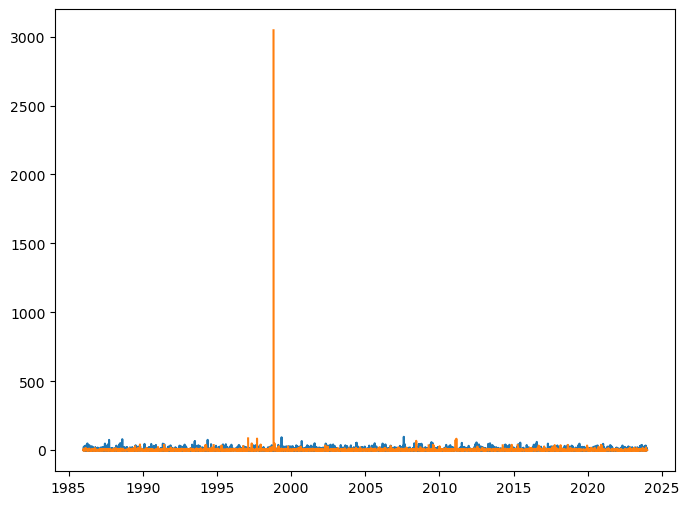

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(data)
plt.plot(generated_data['Sim_1'])


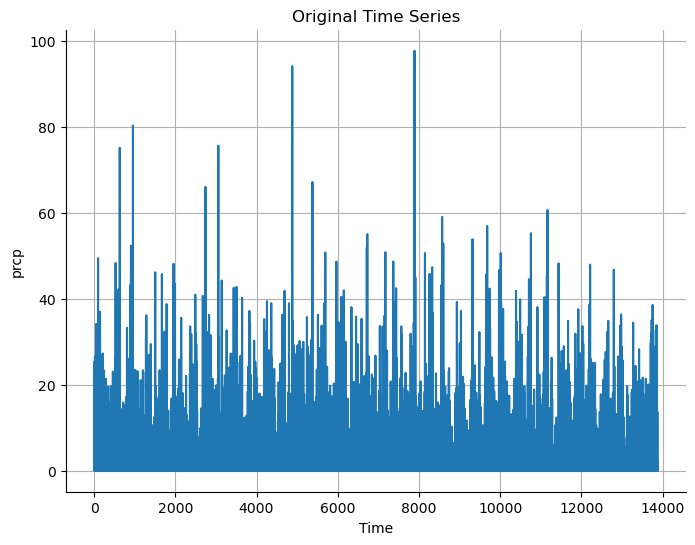

2024-07-10 13:24:29,057 - INFO - Generating 1 trajectories...
2024-07-10 13:24:29,075 - INFO - Final generated trajectories:
2024-07-10 13:24:29,077 - INFO -               Sim_1
count  13250.000000
mean       1.839114
std        4.186051
min        0.000000
25%        0.557708
50%        1.204964
75%        2.131856
max      298.211511


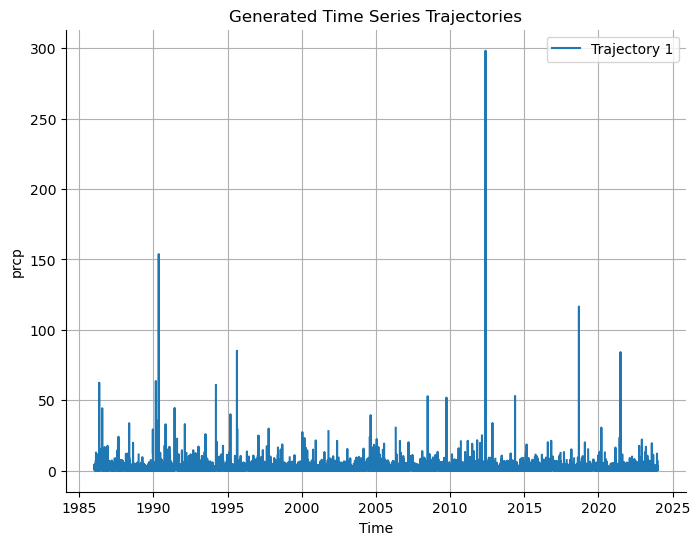

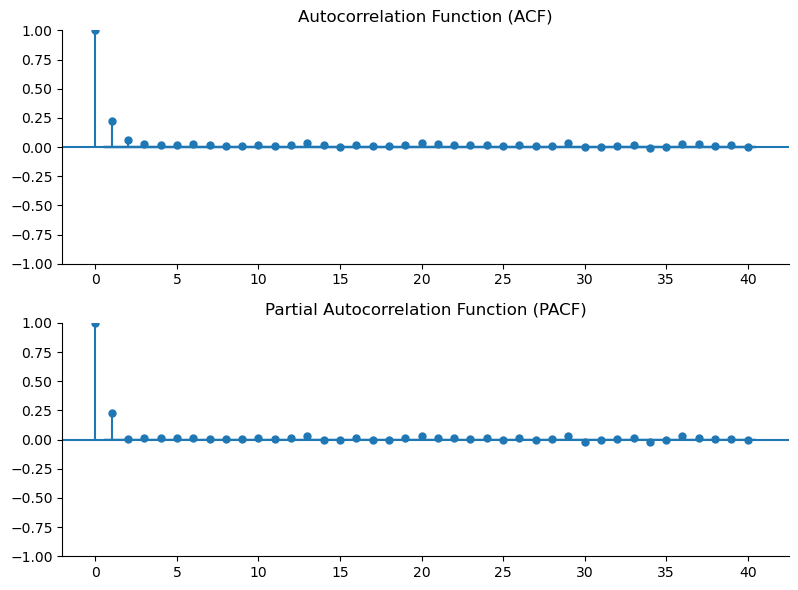

In [19]:
# Plot results
mar_generator.plot_original_data()
mar_generator.plot_generated_trajectories(n_trajectories=1)
mar_generator.display_acf_pacf_plots()